<a href="https://colab.research.google.com/github/leo-lopes/House-pricing-in-Belo-Horizonte/blob/main/Belo_Horizonte_House_pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# House pricing in Belo Horizonte
The goal of this notes is to have some information on the house prices in Belo Horizonte, Minas Gerais, Brazil. The plan is: 
* 1 - Clean and visualize the Data in order to obtain some initial information
* 2 - If possible, apply ML algorithms in the data in order to predict the prices 
* 3 - Obtain some conclusions in what makes the prices higher.

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler

## Clean and visualizating the Data

In [2]:
df = pd.read_csv('data.csv')
df

,address,adm-fees,garage-places,price,rooms,square-foot,neighborhood,city,latitude,longitude
0,"Avenida Raja Gabaglia, 1583",470.0,1,330000.0,1,40,Luxemburgo,Belo Horizonte,-19.936415,-43.953396
1,"Rua Espírito Santo, 1171",NaN,1,480000.0,2,45-65,Centro,Belo Horizonte,-18.864776,-41.121777
2,"Rua dos Expedicionários, 1082",NaN,5,1190000.0,4,411,Santa Amélia,Belo Horizonte,-20.225241,-44.397780
3,"Rua Marechal Hermes, 81",750.0,4,1590000.0,4,158,Gutierrez,Belo Horizonte,-19.937155,-43.958694
4,"Rua Juruna, 110",NaN,6,550000.0,3,278,Pindorama,Belo Horizonte,-19.912982,-44.019944
...,...,...,...,...,...,...,...,...,...,...
5976,Rua Gama Cerqueira,340.0,2,560000.0,3,92,Nova Suíssa,Belo Horizonte,-19.945428,-43.970988
5977,"Rua Arthur Lourenço, 262",200.0,1,440000.0,3,90,Barreiro,Belo Horizonte,-19.979915,-44.026007
5978,Rua General Ephigênio Ruas Santos,10.0,2,500000.0,3,80,Itapoã,Belo Horizonte,-19.840904,-43.956037
5979,Rua General Ephigênio Ruas Santos,10.0,2,740000.0,3,80,Itapoã,Belo Horizonte,-19.840904,-43.956037


In [3]:
df.describe()

,adm-fees,price,latitude,longitude
count,3.977000e+03,5.951000e+03,5981.000000,5981.000000
mean,2.056605e+03,1.075036e+06,-19.910276,-43.932281
std,3.626885e+04,2.127474e+06,0.118853,0.241396
min,1.000000e+00,4.500000e+02,-23.072465,-46.985263
25%,3.000000e+02,3.900000e+05,-19.947275,-43.968233
50%,5.000000e+02,6.800000e+05,-19.929535,-43.945011
75%,1.000000e+03,1.210000e+06,-19.897969,-43.930613
max,1.500000e+06,1.300000e+08,-17.373120,-41.121777


Well, not good news ! The std of adm-fees and price is even greater than the mean. It could be some outliers, we're going investigate that later.

In [4]:
df.isnull().sum()

address             0
adm-fees         2004
garage-places       0
price              30
rooms               0
square-foot         0
neighborhood       24
city                0
latitude            0
longitude           0
dtype: int64

Ok, we have some missing/NaN values, as a first approximation I'm going to change the numerical missing values by the mean of the rest of column. The categorical missing values (just 24) I'm going to write IDK in the missing values.  

In [5]:
df['adm-fees'].fillna(df['adm-fees'].mean(),inplace=True)
df['price'].fillna(df['price'].mean(),inplace=True)
df['neighborhood'].fillna( 'IDK',inplace=True)

In [6]:
df.isnull().sum()

address          0
adm-fees         0
garage-places    0
price            0
rooms            0
square-foot      0
neighborhood     0
city             0
latitude         0
longitude        0
dtype: int64

All right, no more missing values. Let see how many values I have in column 'nieghborhood' and 'adress'. 

In [7]:
counts = df['neighborhood'].value_counts()
counts.to_csv('neigh.csv',index=True)
counts.quantile(0.9)

68.1

In [8]:
counts = df['address'].value_counts()
counts.to_csv('address.csv',index=True)
counts.quantile(0.9)

3.0

The problem in here is that we have too many addresses and neighborhoods in the city, so it may mess the ML algorithm in the future. We have two options: 
* 1 - Just drop these columns. I'm aware that it would affect the analysis but as we have latitude and longitude I think it's not so critical to maintain the address and neigborhood.

* 2 - Sort the neighborhoods and addresses that appeared the least in a new class called 'others'

Let's choose the option 2. The criterion is, if a neighborhood appear less than 1.5* third quarter is going to be classified as others. However, we still have too many adresses, so I'll just trop this column.

In [9]:
df['neighborhood'].unique()

array([' Luxemburgo', ' Centro', ' Santa Amélia', ' Gutierrez',
       ' Pindorama', ' Castelo', ' Santo Antônio', ' Sagrada Família',
       ' Sion', ' Lourdes', ' Santa Efigênia', ' Santa Tereza',
       ' Nova Gameleira', ' São João Batista', ' Nova Suíssa',
       ' São Gabriel', ' Ouro Preto', ' Alto Barroca', ' Goiânia',
       ' Maria Helena', ' Belvedere', ' Cidade Nova', ' Vitória',
       ' Savassi', ' João Pinheiro', ' Itapoã', ' São Tomaz',
       ' Boa Vista', ' Prado', 'IDK', ' Santa Branca', ' São Pedro',
       ' Barro Preto', ' Buritis', ' Colégio Batista', ' Serra',
       ' Santo Agostinho', ' Horto', ' Funcionários', ' Califórnia',
       ' Granja De Freitas', ' Braúnas', ' São Lucas',
       ' Coração Eucarístico', ' Serrano', ' Anchieta', ' Cruzeiro',
       ' Caiçara Adeláide', ' Santa Cruz', ' Vila Paris', ' Gameleira',
       ' São José', ' Mantiqueira', ' Diamante', ' Grajaú',
       ' Santa Lúcia', ' Ipiranga', ' Planalto', ' Barreiro',
       ' São Bento', '

In [10]:
df_clean = df.copy()
neighs = [' Luxemburgo', ' Santa Amélia', ' Gutierrez',
       ' Pindorama', ' Castelo',
       ' Santa Efigênia', ' Santa Tereza',
       ' Nova Gameleira', ' São João Batista', ' Nova Suíssa',
       ' São Gabriel', ' Ouro Preto', ' Alto Barroca', ' Goiânia',
       ' Maria Helena', ' Belvedere', ' Cidade Nova', ' Vitória',
       ' João Pinheiro', ' Itapoã', ' São Tomaz',
       ' Boa Vista', ' Prado', 'IDK', ' Santa Branca', ' São Pedro',
       ' Barro Preto', ' Colégio Batista',
       ' Horto', ' Califórnia',
       ' Granja De Freitas', ' Braúnas', ' São Lucas',
       ' Coração Eucarístico', ' Serrano', ' Anchieta', ' Cruzeiro',
       ' Caiçara Adeláide', ' Santa Cruz', ' Vila Paris', ' Gameleira',
       ' São José', ' Mantiqueira', ' Diamante', ' Grajaú',
       ' Santa Lúcia', ' Ipiranga', ' Planalto', ' Barreiro',
       ' São Bento', ' Pampulha', ' Jardim dos Comerciários',
       ' Bandeirantes', ' Candelaria', ' Juliana', ' Bonfim', ' Marajó',
       ' Floresta', ' Penha', ' Santa Mônica', ' Venda Nova',
       ' Nova Granada', ' Cachoeirinha', ' Padre Eustáquio', ' Itatiaia',
       ' São Luíz', ' União', ' Santa Inês', ' Floramar', ' Liberdade',
       ' Jardim Guanabara', ' Carlos Prates', ' Graça', ' Beija Flor',
       ' Palmares', ' Concórdia', ' Copacabana', ' Santa Maria',
       ' Madre Gertrudes', ' Providência', ' Dona Clara', ' Estoril',
       ' Nova Vista', ' Jonas Veiga', ' Ouro Minas', ' Cinqüentenário',
       ' Cidade Jardim', ' Havaí', ' Serra Verde', ' Álvaro Camargos',
       ' Estrela Dalva', ' Calafate', ' Barroca', ' Frei Leopoldo',
       ' Paquetá', ' Canaã', ' Paraíso', ' Guarani',
       ' Alto dos Pinheiros', ' Caiçaras', ' Mangabeiras', ' Heliópolis',
       ' Jaraguá', ' Comiteco', ' Etelvina Carneiro', ' Jardim Leblon',
       ' Alípio de Melo', ' Manacás', ' Carmo', ' Betânia',
       ' Estrela do Oriente', ' Saudade', ' Vale do Sereno',
       ' Renascença', ' Jardim Vitória', ' Aparecida',
       ' Vale dos Cristais', ' Jardim América', ' Santa Helena',
       ' Novo das Indústrias', ' Xodó Marize', ' Palmeiras', ' Amazonas',
       ' Maria Tereza', ' Perobas', ' Letícia', ' Bom Jesus',
       ' Vale do Jatoba Barreiro', ' Jardim Riacho das Pedras',
       ' Chacaras Del Rey Sao Benedito', ' Rio Branco', ' Granja Verde',
       ' Esperanca Justinopolis', ' Fernão Dias', ' Sapucaia II',
       ' Camargos', ' Lundcea', '040', ' Santa Terezinha', ' Silveira',
       ' Quintino', ' Europa', ' Casa Branca', ' Parque Leblon',
       ' Céu Azul', ' Alto dos Caiçaras', ' Salgado Filho', ' Pirajá',
       ' Monsenhor Messias', 'I', ' Trevo', ' Jardim Atlântico',
       ' Santa Rosa', ' Garças', ' Piratininga Venda Nova',
       ' Minaslandia P Maio', ' Jardim Europa venda Nova', ' Jaqueline',
       ' São Cristóvão', ' São Geraldo', ' São Francisco', ' Bonsucesso',
       ' Miramar', ' Vila Clóris', ' Vera Cruz', ' Sinimbu', ' Tirol',
       ' Engenho Nogueira', ' Glória', ' Jardim Paqueta', ' Minas Brasil',
       ' Bonsucesso Barreiro', ' Parque São José', ' Milionários',
       ' Solar do Barreiro', ' Lagoinha', ' Novo Glória', ' Araguaia',
       ' Dom Bosco', ' Coração de Jesus', ' Primeiro de Maio',
       ' Vista Alegre', ' Nova Floresta', ' Nazaré',
       ' Flávio Marques Lisboa', ' Visconde do Rio Branco', ' Pompéia',
       ' Cenaculo', ' Vila Oeste', ' Olaria', ' Minascaixa', ' Esplanada',
       ' Brasil Industrial', ' Minaslândia', ' Parque Copacabana',
       ' São Salvador', ' Ipê', ' Glalijá', ' Jardim Montanhês',
       ' Jardim dos Pirineus', ' Distrito Industrial Vale do Jatobá',
       ' Conjunto Jardim Filadélfia', ' Santo André', ' Cardoso Barreiro',
       ' Coqueiros', ' Parque Sao Pedro Venda Nova', ' Novo Letícia',
       ' Conjunto Celso Machado', ' Castanheira', ' Itaipu Barreiro',
       ' Santa Sofia', ' Maria Virgínia', ' Teixeira Dias Barreiro',
       ' Horto Florestal', ' Aeroporto', ' Conjunto Califórnia', ' Urca',
       ' Vila da Serra', ' Parque Pedro II', ' Petrópolis']
subs = { key : 'Other' for key in neighs}
df_clean['neighborhood'] = df_clean['neighborhood'].replace(subs)

In [11]:
df_clean['neighborhood'].unique()

array(['Other', ' Centro', ' Santo Antônio', ' Sagrada Família', ' Sion',
       ' Lourdes', ' Savassi', ' Buritis', ' Serra', ' Santo Agostinho',
       ' Funcionários'], dtype=object)

In [12]:
df_clean.drop('address',axis=1,inplace=True)

In [13]:
df_clean

,adm-fees,garage-places,price,rooms,square-foot,neighborhood,city,latitude,longitude
0,470.00000,1,330000.0,1,40,Other,Belo Horizonte,-19.936415,-43.953396
1,2056.60523,1,480000.0,2,45-65,Centro,Belo Horizonte,-18.864776,-41.121777
2,2056.60523,5,1190000.0,4,411,Other,Belo Horizonte,-20.225241,-44.397780
3,750.00000,4,1590000.0,4,158,Other,Belo Horizonte,-19.937155,-43.958694
4,2056.60523,6,550000.0,3,278,Other,Belo Horizonte,-19.912982,-44.019944
...,...,...,...,...,...,...,...,...,...
5976,340.00000,2,560000.0,3,92,Other,Belo Horizonte,-19.945428,-43.970988
5977,200.00000,1,440000.0,3,90,Other,Belo Horizonte,-19.979915,-44.026007
5978,10.00000,2,500000.0,3,80,Other,Belo Horizonte,-19.840904,-43.956037
5979,10.00000,2,740000.0,3,80,Other,Belo Horizonte,-19.840904,-43.956037


In [14]:
df_clean['city'].value_counts()

 Belo Horizonte         5925
Belo Horizonte            24
 Contagem                  6
 Nova Lima                 4
 Sabará                    4
 Ribeirão das Neves        3
 Lagoa Santa               2
 461                       2
 1542                      1
 22                        1
 São Paulo                 1
 1601                      1
 570                       1
 Divinópolis               1
 1122                      1
 Km 480                    1
 Betim                     1
 Santa Luzia               1
 31                        1
Name: city, dtype: int64

As 99% of the city are 'Belo Horizonte' doesn't make sense to keep this column, so I'll drop that.

In [15]:
df_clean.drop('city',axis=1,inplace=True)

In [16]:
df_clean

,adm-fees,garage-places,price,rooms,square-foot,neighborhood,latitude,longitude
0,470.00000,1,330000.0,1,40,Other,-19.936415,-43.953396
1,2056.60523,1,480000.0,2,45-65,Centro,-18.864776,-41.121777
2,2056.60523,5,1190000.0,4,411,Other,-20.225241,-44.397780
3,750.00000,4,1590000.0,4,158,Other,-19.937155,-43.958694
4,2056.60523,6,550000.0,3,278,Other,-19.912982,-44.019944
...,...,...,...,...,...,...,...,...
5976,340.00000,2,560000.0,3,92,Other,-19.945428,-43.970988
5977,200.00000,1,440000.0,3,90,Other,-19.979915,-44.026007
5978,10.00000,2,500000.0,3,80,Other,-19.840904,-43.956037
5979,10.00000,2,740000.0,3,80,Other,-19.840904,-43.956037


Ok, Now we are going look for some outliers in the data. In the information about the 'adm-fees' and the 'prices' I see that the third quarter is about 1e3 but the maximum is 1e6 for the adm-fees. As I know that is quite impossible to have a adm fee in order of 1e6 it's clearly an outlier. So i'm going to drop any row that have the adm-fee bigger than 2*(third quartile). The same logical applies to the price.

In [17]:
print('the third quantile is',df_clean['adm-fees'].quantile(0.75))
df_clean = df_clean[df_clean['adm-fees'] < 2*2056]

the third quantile is 2056.6052300729193


In [18]:
print('the third quantile is',df_clean['price'].quantile(0.75))
df_clean = df_clean[df_clean['price'] < 2*1200000.0]

the third quantile is 1200000.0


In [19]:
df_clean

,adm-fees,garage-places,price,rooms,square-foot,neighborhood,latitude,longitude
0,470.00000,1,330000.0,1,40,Other,-19.936415,-43.953396
1,2056.60523,1,480000.0,2,45-65,Centro,-18.864776,-41.121777
2,2056.60523,5,1190000.0,4,411,Other,-20.225241,-44.397780
3,750.00000,4,1590000.0,4,158,Other,-19.937155,-43.958694
4,2056.60523,6,550000.0,3,278,Other,-19.912982,-44.019944
...,...,...,...,...,...,...,...,...
5975,200.00000,--,220000.0,1,45,Buritis,-19.974455,-43.977699
5976,340.00000,2,560000.0,3,92,Other,-19.945428,-43.970988
5977,200.00000,1,440000.0,3,90,Other,-19.979915,-44.026007
5978,10.00000,2,500000.0,3,80,Other,-19.840904,-43.956037


OK, now we can have some information abou the prices in the city. First, let's take a look in the correlation between numerical variables

In [20]:

graph = px.scatter_matrix(df_clean,dimensions=['adm-fees','square-foot','neighborhood'], color = 'price',height=750)
graph.show()

Our first conclusion is : The price is proportional to the 'adm-fees'. A second, and unexpected one, conclusion is that the price is not correlated to the square-foot. I tend to explain that saying that the bigger houses are in 'poor' neighborhoods, but it needs more information on that. Let's now see the price by neighborhood. Just to make it clear, the lines that appears in the images is the values I filled with the mean. 

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



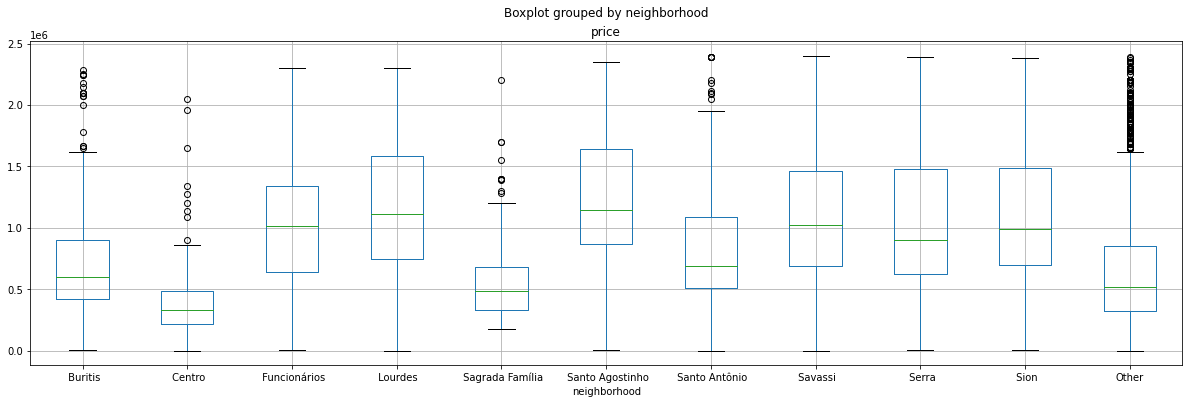

In [21]:
df_clean.boxplot(column='price', by='neighborhood',figsize=(20,6))

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



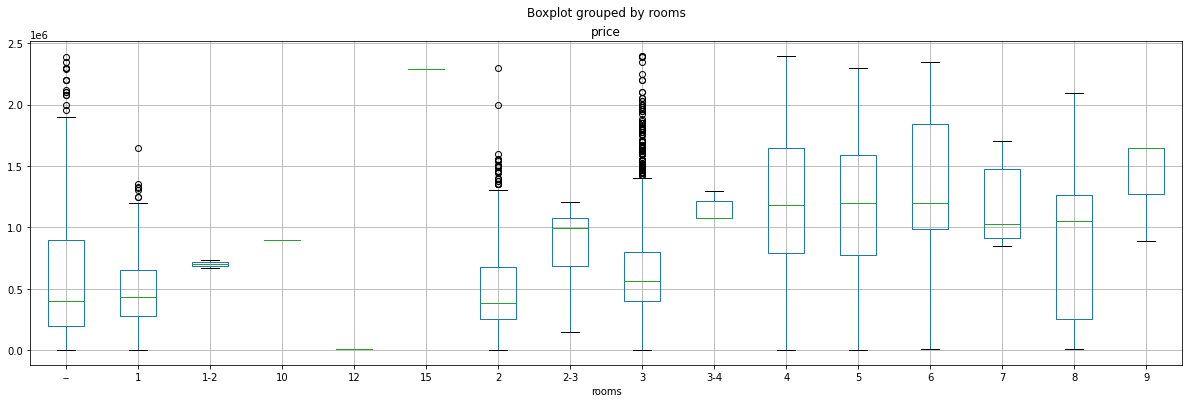

In [22]:
df_clean.boxplot(column='price', by='rooms', figsize=(20,6))

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



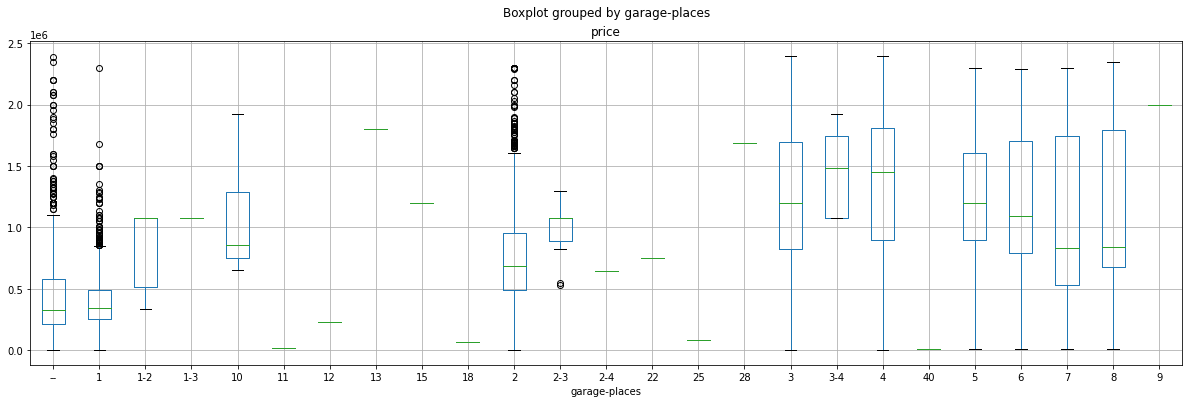

In [23]:
df_clean.boxplot(column='price', by='garage-places', figsize=(20,6))

We can see that the garage-places doesn't influences too much to the price house, so in this point I'm going to drop it. Beside that, I'm going drop the 'square-foot' too, as we said it does not influences in the house prices.

In [24]:
df_clean.drop('garage-places',axis=1,inplace=True)

In [25]:
df_clean.drop('square-foot',axis=1,inplace=True)

In [26]:
df_clean['longitude'].min()

-46.9852627

In [27]:
df_clean['longitude'].max()

-41.1217768

And we can plot a scatter of latitude and longitude with the colormap price and see which regions are more expensive.

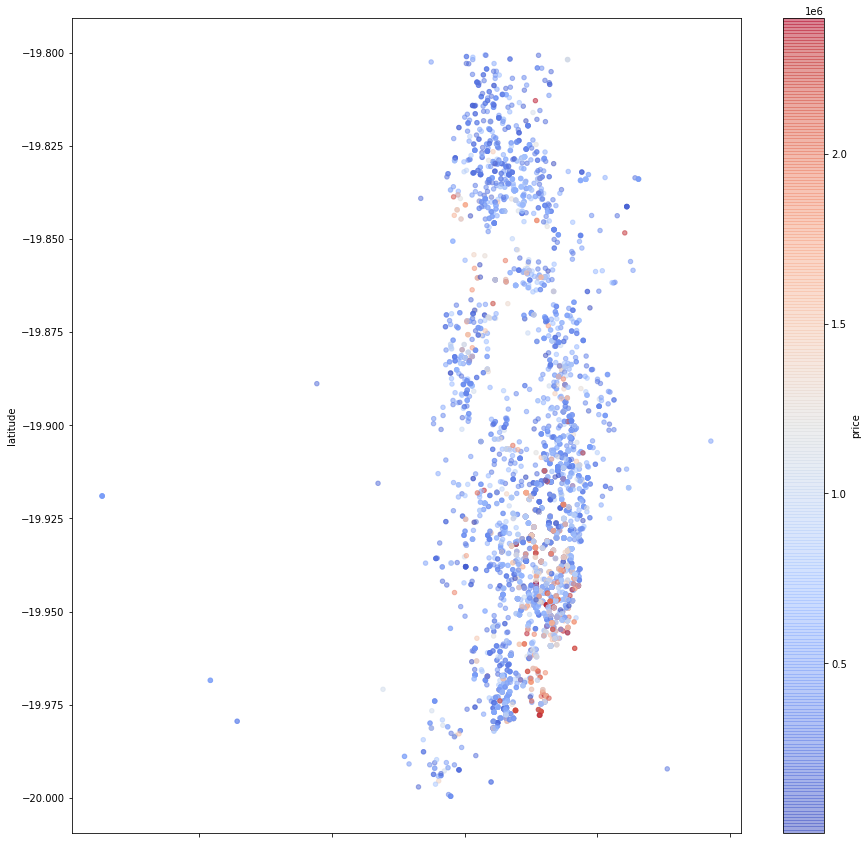

In [28]:
df_clean[(df_clean['latitude'] > -20.0) & (df_clean['latitude'] < -19.8) & (df_clean['longitude'] < -43.8) & (df_clean['longitude'] > -44.8) ].plot.scatter(x='longitude', y='latitude', c='price', figsize=(15,15), cmap='coolwarm', alpha=0.5)

We can conclude that the houses in the south but close to the downtown is more expensive. We have some expensive houses in the North-west.

So, now I think is a good moment too try to apply ML in the data in order to build a model that predicts the house prices.

## Machine Learning Models

## Preparation

In [29]:
df_clean.columns

Index(['adm-fees', 'price', 'rooms', 'neighborhood', 'latitude', 'longitude'], dtype='object')

In [30]:
x=df_clean.loc[:,['adm-fees','rooms', 'neighborhood', 'latitude', 'longitude']].values #classifiers
y = df_clean.iloc[:,1].values#class

In [31]:
#Encoder
from sklearn.preprocessing import LabelEncoder
label_encoder_neigh = LabelEncoder()
label_encoder_rooms= LabelEncoder()

In [32]:
x[:,2] = label_encoder_neigh.fit_transform(x[:,2])
x[:,1] = label_encoder_rooms.fit_transform(x[:,2])

In [33]:
#Scaling
# we're going to use StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [34]:
#spliting the data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.15, random_state = 0)

## Linear model

In [35]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(x_train,y_train)

LinearRegression()

In [36]:
predictions = regressor.predict(x_test)

In [37]:
regressor.coef_

array([ 1.72495822e+05,  2.66816406e+18, -2.66816406e+18, -7.99360000e+04,
        7.21920000e+04])

In [38]:
#Mean absolute error
from sklearn.metrics import mean_absolute_error,mean_squared_error
mean_absolute_error(predictions,y_test)

367702.9012244146

In [39]:
y_test.mean()

768626.3740909359

At this moment the Mean absolute error represents 44% of the mean. Beside that, if we look at the coefficients we can see that they're really great and a coefficients vanishes the another one. So we must use LASSO (or Ridge) to normalize the coefficients. 

In [55]:
# We need to do a normalized linearization
from sklearn import linear_model
rg = linear_model.Lasso(alpha=0.0001)
rg.fit(x_train,y_train)

Lasso(alpha=0.0001)

In [56]:
prev_lasso = rg.predict(x_test)

In [57]:
rg.coef_

array([ 1.72495822e+05, -4.07627249e+04, -1.56585072e-11, -9.57095237e+04,
        7.38892476e+04])

In [58]:
mean_absolute_error(y_test,prev_lasso)

367849.3963662979

The coefficients of order 18 has gone, but before we try more sofisticated methods we must try Ridge.

In [60]:
from sklearn.linear_model import Ridge
rg = Ridge(alpha=0.01)
rg.fit(x_train,y_train)

Ridge(alpha=0.01)

In [62]:
prev_ridge=rg.predict(x_test)

In [65]:
rg.coef_

array([172495.47197919, -20381.39445512, -20381.3944516 , -95708.9282025 ,
        73888.67987121])

In [64]:
mean_absolute_error(prev_ridge,y_test)

367849.48306292854

OK, we are going to try to have best predctions using another ML methods. Let's start with RandomForest.

In [69]:
from sklearn.ensemble import RandomForestClassifier

In [74]:
from sklearn.ensemble import RandomForestRegressor
regressor_random_forest = RandomForestRegressor()
regressor_random_forest.fit(x_train,y_train)

RandomForestRegressor()

In [77]:
prediction_tree = regressor_random_forest.predict(x_test)

In [78]:
mean_absolute_error(prediction_tree,y_test)

239787.42090831793

The RandomForestRegressor gives a better result and we can know the price of a house with a MAE equals to 30% of the mean. It's hard to have a better result than that because we have too many variables, however I'm going to try another approach. I'm going to classify the price of a house into a range and use algorithms of classifications rather than the regression algorithms.

In [99]:
df_range = df_clean.copy()

In [80]:
df_range

,adm-fees,price,rooms,neighborhood,latitude,longitude
0,470.00000,330000.0,1,Other,-19.936415,-43.953396
1,2056.60523,480000.0,2,Centro,-18.864776,-41.121777
2,2056.60523,1190000.0,4,Other,-20.225241,-44.397780
3,750.00000,1590000.0,4,Other,-19.937155,-43.958694
4,2056.60523,550000.0,3,Other,-19.912982,-44.019944
...,...,...,...,...,...,...
5975,200.00000,220000.0,1,Buritis,-19.974455,-43.977699
5976,340.00000,560000.0,3,Other,-19.945428,-43.970988
5977,200.00000,440000.0,3,Other,-19.979915,-44.026007
5978,10.00000,500000.0,3,Other,-19.840904,-43.956037


In [84]:
# the maximum and minimum prices
print('the minimum price is ',df_range['price'].min())
print('the maximum price is ',df_range['price'].max())
print('the mean price is ',df_range['price'].mean())

the minimum price is  450.0
the maximum price is  2399000.0
the mean price is  760041.0691559635


It's quite impossible to have a price of a house of 450.0. So I'm gonna drop every price less than 50000 and bigger than 2M.

In [100]:
df_range = df_range[(df_range['price'] > 50000) & (df_range['price'] < 2000000)]

In [101]:
# the maximum and minimum prices
print('the minimum price is ',df_range['price'].min())
print('the maximum price is ',df_range['price'].max())
print('the mean price is ',df_range['price'].mean())

the minimum price is  54000.0
the maximum price is  1998193.0
the mean price is  725055.7275789469


All right, let's divide the price in ranges.

In [103]:
bins = [50000,150000,250000,350000,450000,550000,650000,750000,850000,950000,1050000,1150000,1250000,1350000,1450000,1550000,1650000,1750000,1850000,1950000,2050000]
df_range['price'] = pd.cut(df_range['price'], bins)

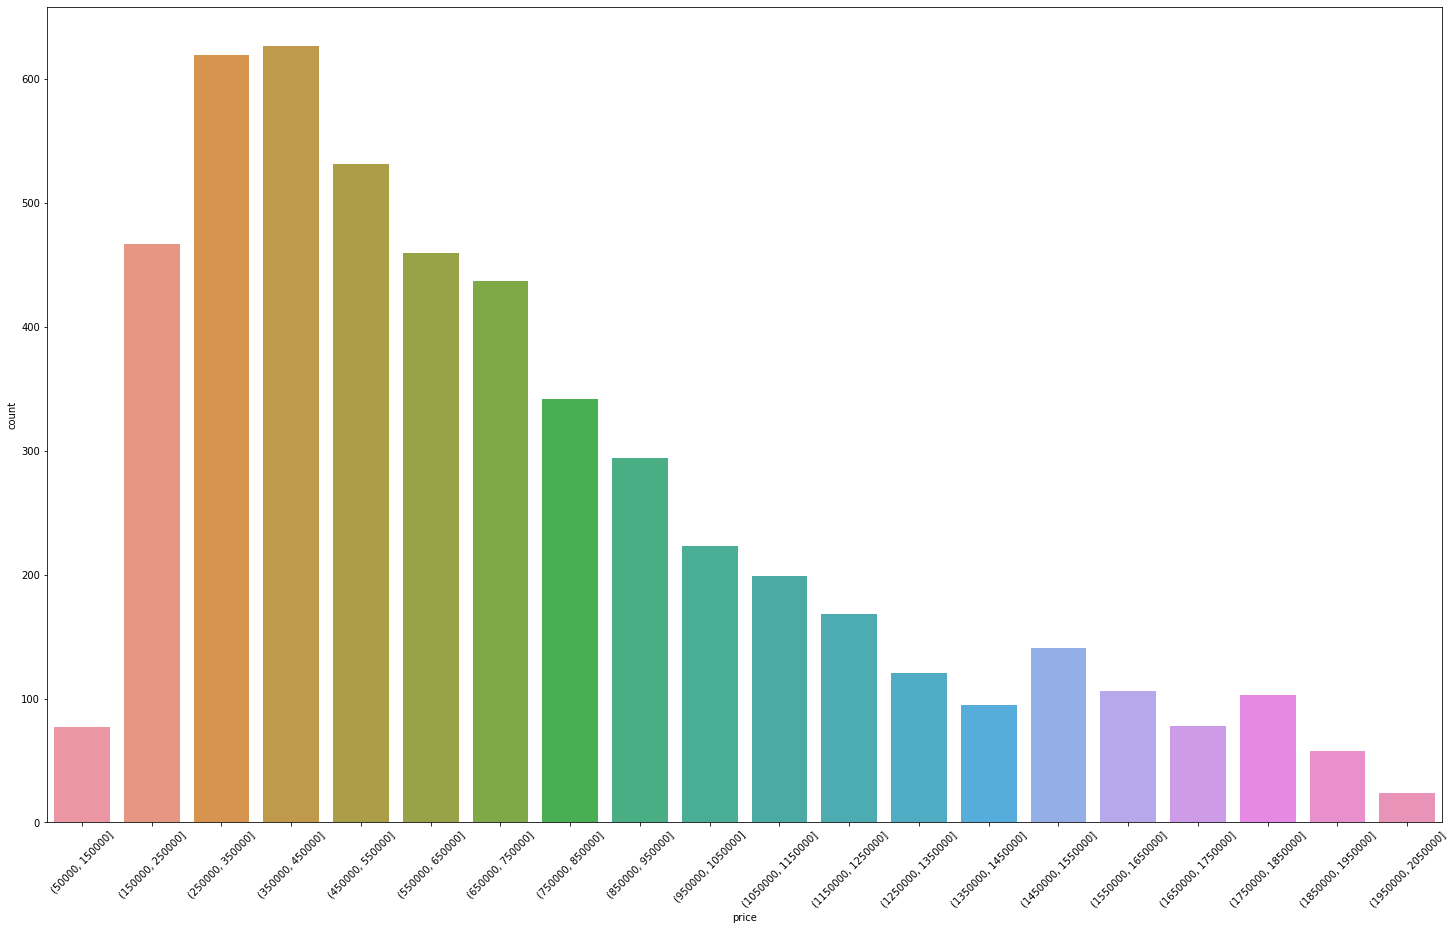

In [108]:
ax=sns.countplot(x = df_range['price']);
plt.xticks(rotation=45)
ax.figure.set_size_inches(25, 15)

In [109]:
df_range

,adm-fees,price,rooms,neighborhood,latitude,longitude
0,470.00000,"(250000, 350000]",1,Other,-19.936415,-43.953396
1,2056.60523,"(450000, 550000]",2,Centro,-18.864776,-41.121777
2,2056.60523,"(1150000, 1250000]",4,Other,-20.225241,-44.397780
3,750.00000,"(1550000, 1650000]",4,Other,-19.937155,-43.958694
4,2056.60523,"(450000, 550000]",3,Other,-19.912982,-44.019944
...,...,...,...,...,...,...
5975,200.00000,"(150000, 250000]",1,Buritis,-19.974455,-43.977699
5976,340.00000,"(550000, 650000]",3,Other,-19.945428,-43.970988
5977,200.00000,"(350000, 450000]",3,Other,-19.979915,-44.026007
5978,10.00000,"(450000, 550000]",3,Other,-19.840904,-43.956037


Now, we have to use classification algorithms instead regression algortihms. Let's start with random forest.

In [150]:
x=df_range.loc[:,['adm-fees','rooms', 'neighborhood','longitude','latitude']].values #classifiers
y = df_range.iloc[:,1].values#class

In [151]:
#Encoder
from sklearn.preprocessing import LabelEncoder
label_encoder_neigh = LabelEncoder()
label_encoder_rooms= LabelEncoder()

In [152]:
from sklearn.preprocessing import LabelEncoder
label_encoder_y = LabelEncoder()
y_range = label_encoder_y.fit_transform(y)

In [153]:
x[:,2] = label_encoder_neigh.fit_transform(x[:,2])
x[:,1] = label_encoder_rooms.fit_transform(x[:,2])

In [154]:
#Scaling
# we're going to use StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [155]:
#spliting the data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y_range, test_size = 0.15, random_state = 0)

In [156]:
from sklearn.ensemble import RandomForestClassifier
tree = RandomForestClassifier(criterion='entropy',random_state=0)
tree.fit(x_train,y_train)

RandomForestClassifier(criterion='entropy', random_state=0)

In [159]:
prev = tree.predict(x_test)
prev

array([ 6,  7,  5,  5, 16,  8,  2, 10, 11,  5,  3,  1,  8,  8,  1, 10, 17,
        3,  6,  9,  3, 11,  3,  6,  5,  2,  5,  6, 12, 17,  2,  7,  3, 12,
        9,  5, 11,  1,  4,  6, 11,  3,  5,  2,  1, 13,  2,  4,  8,  3,  6,
        3,  7,  2,  2,  3,  0,  6, 13, 10,  4,  5,  8,  5,  2,  6,  7,  7,
       14,  8,  2,  5, 10,  2, 11,  5,  3,  3,  4,  7,  4, 14,  8,  4,  1,
        2, 11,  3,  3,  0,  1,  1,  6,  3,  9,  6,  6,  6,  7, 10, 10,  0,
        2, 11,  4,  7,  3,  1,  6,  2,  3,  3,  3,  2,  2,  3, 18,  4,  3,
        1,  3,  6,  2,  1,  4,  5,  2, 13,  7,  3,  9,  4,  4,  3,  5,  7,
        8,  1,  4, 10,  5,  4,  3,  6, 15,  6,  6,  8,  8,  4, 18,  3,  2,
        2,  4,  2,  6,  2,  5,  1,  2,  2,  6, 11,  7,  3,  4,  2,  1,  4,
        5,  1,  2,  2,  1, 16,  2, 11,  3,  2,  4,  4,  3,  1, 13,  6,  9,
        8,  6, 10,  7,  7, 14,  1, 12,  8,  6,  8, 16,  6,  2,  5,  7,  7,
        3,  2,  2,  6,  7,  3,  6,  3,  8,  1,  3,  3, 14,  1,  2,  3,  9,
        3,  2, 11, 15,  2

In [158]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy_score(y_test, prev)

0.3002577319587629

Well, as I divided in a range of 100k and we score 30% of the predictions, it's better use the RandomForestRegression, which has a 30% of deviation from mean. 

Conclusions
* 1 - The adm-fees is the key to the prices raising.
* 2 - The neighborhood doesn't influences too much, we only have some regions in the city where the houses are really expensive.
* 3 - The number of rooms and the square foot also don't influence the price (looking in differents neighborhoods), probably because poor neighborhoods have bigger houses.